# LendingClub: Automating Lending Decisions
# Part 1. Loan Acceptance

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction     ](#toc1_)    
- 2. [Notebook and Data Preparation     ](#toc2_)    
- 3. [Exploratory Data Analysis     ](#toc3_)    
  - 3.1. [Loan Application and Acceptance Dynamics     ](#toc3_1_)    
  - 3.2. [Basic Data Understanding     ](#toc3_2_)    
  - 3.3. [Exporting Data for Model Development     ](#toc3_3_)    
  - 3.4. [Variable Relationships     ](#toc3_4_)    
  - 3.5. [Time and Geographical Insights     ](#toc3_5_)    
  - 3.6. [Summary on Exploratory Data Analysis     ](#toc3_6_)    
- 4. [Loan Acceptance and Rejection Model     ](#toc4_)    
  - 4.1. [Evaluation and Interpretation ](#toc4_1_)    
  - 4.2. [Deployment ](#toc4_2_)    
  - 4.3. [Summary on Modeling](#toc4_3_)    
- 5. [Recommendations     ](#toc5_)    
- 6. [Suggestions for Improvement  ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction      [&#8593;](#toc0_)

LendingClub wants to automate their lending decisions fully and has provided old loan data from the middle of 2007 to the end of 2018 to build machine learning models for that. The process of lending automation is expected to happen in 3 steps:
1. loan classification into accepted and rejected;
2. prediction of the loan grade;
3. prediction of the loan subgrade and interest rate.

In this part, only the **1st step** is addressed. The company wants a model accurate for both loan classes: accepted and rejected. Therefore, balanced accuracy is aimed to improve. The last month of data is used for testing to better evaluate possible model's performance in the future. Validation is performed on the month before the last.

The **aim** is to analyze accepted and rejected loans and provide insights for the Lending Club.

The **objectives** are as follows:
* Explore the dataset to identify important features;
* Build a model to improve loan classification into accepted and rejected;
* Deploy a models to the Google Cloud Platform.


## 2. <a id='toc2_'></a>Notebook and Data Preparation      [&#8593;](#toc0_)

Import libraries for data analysis, visualization and modelling. Set parameters for display.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from polars import col as c
import seaborn as sns
import phik
import seaborn.objects as so
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from sklearn.pipeline import Pipeline
from helper_functions import lc_data_utils
from helper_functions.ml_data_prep import (
    X_y_spilt,
    stratified_sample,
)
from helper_functions.custom_model import score_binary_fitted_classifiers, plot_shap_values
from sklearn.base import BaseEstimator, ClassifierMixin
from urllib.request import urlopen
import json
import joblib

target="target"

# Display
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.labelsize": 11,
    "figure.figsize": (5, 3.5),
    "figure.autolayout": True,  
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
    "legend.frameon": False,
    "axes.titlesize": "large",
    "figure.titlesize":   "large", 
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3)
facecolor = sns.color_palette()[0]
emphasiscolor = sns.color_palette()[3]

%matplotlib inline
%config InlineBackend.figure_format = 'png'

Download and unzip the dataset in the `data` folder from the [storage](https://storage.googleapis.com/335-lending-club/lending-club.zip). Table of the rejected loans has only 9 features. Their naming is adjusted to accommodate consistency with the table of the accepted loans. 

Risk score of the accepted loans is presented as FICO score range. For the rejected applications prior to November 5, 2013 the risk score is the borrower's FICO score. For the rejected applications after November 5, 2013 the risk score is the borrower's Vantage score as explained in the analysis on [Medium](https://petersoninquiries.medium.com/loan-analysis-using-python-and-lending-club-data-5475e1a9844). To unify the representation these scores are represented as risk levels from F to A. If the risk score is outside the range it is imputed as null.
| Risk Score | FICO | Vantage |
| :-: | :-: | :-: |
| A | 800-850 | 900-990 |
| B | 740-799 | 800-899 |
| C | 670-739 | 700-799 |
| D | 580-669 | 600-699 |
| F | 300-579 | 300-599 |

There are more than 27 million entries in the rejected table and more than a million applications might be considered as duplicates (date granularity of month). However, these are kept for now as they might correspond with multiple attempts to obtain a loan, which actually needs to be rejected.

In [2]:
rejected_dataset_file = "./data/rejected_2007_to_2018Q4.csv"
rejected_df = lc_data_utils.rejected_data_load(rejected_dataset_file)
lc_data_utils.display_basic_info(rejected_df)

loan_amnt,date,purpose,dti,zip_code,state,emp_length,policy_code,dti_joint,risk_score,target
f64,date,str,f64,str,str,str,f64,f64,str,i8
1000.0,2007-05-01,"""wedding""",10.0,"""481xx""","""NM""","""4 years""",0.0,null,"""C""",0
1000.0,2007-05-01,"""debt_consolida…",10.0,"""010xx""","""MA""","""< 1 year""",0.0,null,"""C""",0
11000.0,2007-05-01,"""debt_consolida…",10.0,"""212xx""","""MD""","""1 year""",0.0,null,"""C""",0
6000.0,2007-05-01,"""other""",38.64,"""017xx""","""MA""","""< 1 year""",0.0,null,"""C""",0
1500.0,2007-05-01,"""other""",9.43,"""209xx""","""MD""","""< 1 year""",0.0,null,"""F""",0


Loans are from 2007-05-01 to 2018-12-01.
Number of loans: 27648741
Number of duplicates: 1473270


Table of the accepted loans has much more features:

In [3]:
accepted_dataset_file = "./data/accepted_2007_to_2018Q4.csv"
pl.read_csv(accepted_dataset_file, n_rows=1).columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

However, for the initial step only part of them are considered. These are the features most probably related to the features from the rejected loans:
* **loan_amnt**	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* **issue_d**	The month which the loan was funded
* **purpose** A category provided by the borrower for the loan request. 
* **fico_range_high**	The upper boundary range the borrower’s FICO at loan origination belongs to.
* **fico_range_low**	The lower boundary range the borrower’s FICO at loan origination belongs to.
* **dti**	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* **dti_joint**	A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income
* **zip_code**	The first 3 numbers of the zip code provided by the borrower in the loan application.
* **addr_state**	The state provided by the borrower in the loan application
* **emp_length**	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
* **policy_code**	publicly available policy_code=1, new products not publicly available policy_code=2

The low FICO is used to calculate risk score for the accepted loan dataframe. There are more than 2 million entries in this table and 70 applications might be considered as duplicates. Again these are kept for analysis.

In [4]:
accepted_df = lc_data_utils.accepted_data_load(accepted_dataset_file)
full_df = accepted_df.vstack(rejected_df).sort(by="date")
lc_data_utils.display_basic_info(accepted_df)

loan_amnt,date,purpose,dti,zip_code,state,emp_length,policy_code,dti_joint,risk_score,target
f64,date,str,f64,str,str,str,f64,f64,str,i8
3600.0,2015-12-01,"""debt_consolida…",5.91,"""190xx""","""PA""","""10+ years""",1.0,null,"""C""",1
24700.0,2015-12-01,"""small_business…",16.06,"""577xx""","""SD""","""10+ years""",1.0,null,"""C""",1
20000.0,2015-12-01,"""home_improveme…",10.78,"""605xx""","""IL""","""10+ years""",1.0,13.85,"""C""",1
35000.0,2015-12-01,"""debt_consolida…",17.06,"""076xx""","""NJ""","""10+ years""",1.0,null,"""B""",1
10400.0,2015-12-01,"""major_purchase…",25.37,"""174xx""","""PA""","""3 years""",1.0,null,"""C""",1


Loans are from 2007-06-01 to 2018-12-01.
Number of loans: 2260668
Number of duplicates: 70


For exploring in detail data cleaning and feature engineering of risk score and DTI, see `lc_data_utils.py` file from helper functions.

## 3. <a id='toc3_'></a>Exploratory Data Analysis      [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Loan Application and Acceptance Dynamics      [&#8593;](#toc0_)

The number of loan application continuously increases. Approximately 10 times more applications are rejected than accepted. This gap is even more increasing in the later years. However, there was a decrease in loan application coinciding with the Great Recession.

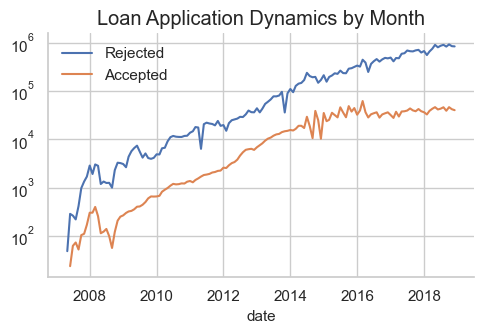

In [5]:
loan_counts = (
    full_df.pivot(
        values=target,
        index="date",
        columns=target,
        aggregate_function="count",
    )
    .to_pandas()
    .set_index("date")
)
loan_counts.rename(columns={"0": "Rejected", "1": "Accepted"}, inplace=True)
sns.lineplot(data=loan_counts, dashes=False)
plt.yscale("log")
plt.title("Loan Application Dynamics by Month")
plt.show()

This is also seen in the reduced loan acceptance ratio. However, there are 3 spikes in acceptance ratio and the later two is mostly related to the smaller number of rejected loan applications.

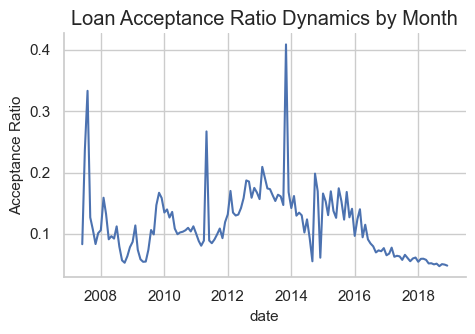

In [6]:
loan_counts["Acceptance Ratio"] = loan_counts.apply(
    lambda x: x["Accepted"] / x["Rejected"], axis=1
)
sns.lineplot(data=loan_counts, y="Acceptance Ratio", x="date")
plt.title("Loan Acceptance Ratio Dynamics by Month")
plt.show()

Below are yearly numbers.

In [7]:
loans_by_year = loan_counts.groupby(by=loan_counts.index.year)[
    ["Accepted", "Rejected"]
].sum()
loans_by_year["Acceptance Ratio"] = loans_by_year.apply(
    lambda x: x["Accepted"] / x["Rejected"], axis=1
)
loans_by_year

,Accepted,Rejected,Acceptance Ratio
date,,,
2007,603.0,5274,0.114
2008,2393.0,25596,0.093
2009,5281.0,56991,0.093
2010,12537.0,112561,0.111
2011,21721.0,217792,0.100
2012,53367.0,337277,0.158
2013,134814.0,760942,0.177
2014,235629.0,1933700,0.122
2015,421095.0,2859379,0.147


Further on data from the last month of 2018 is holdout for testing. The remaining data is used for EDA, model training and validation. However, data from 2007-05 is also ignored as no accepted loans are from this month.

In [8]:
data_test = full_df.filter(c.date >= datetime(2018, 12, 1))
data_eda = full_df.filter(
    c.date.is_between(datetime(2007, 6, 1), datetime(2018, 11, 1))
)
print(
    f"Size of EDA instances {data_eda.shape[0]},"
    f" {data_eda.shape[0]/full_df.shape[0]:.1%} of total"
)
print(
    f"Size of test instances {data_test.shape[0]},"
    f" {data_test.shape[0]/full_df.shape[0]:.1%} of total"
)

Size of EDA instances 29034857, 97.1% of total
Size of test instances 874503, 2.9% of total


### 3.2. <a id='toc3_2_'></a>Basic Data Understanding      [&#8593;](#toc0_)

Policy code does not seem as a viable feature to use, as 1 is used for accepted loans, and 0 and 2 - for rejected loans.  Also, -1 seems to be encoding missing DTI.

In [9]:
print("Accepted Loans:")
display(data_eda.filter(pl.col(target) == 1).describe())
print("Rejected Loans:")
display(data_eda.filter(pl.col(target) == 0).describe())

Accepted Loans:


describe,loan_amnt,date,purpose,dti,zip_code,state,emp_length,policy_code,dti_joint,risk_score,target
str,f64,str,str,f64,str,str,str,f64,f64,str,f64
"""count""",2.220534e6,"""2220534""","""2220534""",2.218896e6,"""2220533""","""2220534""","""2077314""",2.220534e6,115693.0,"""2220534""",2.220534e6
"""null_count""",0.0,"""0""","""0""",1638.0,"""1""","""0""","""143220""",0.0,2.104841e6,"""0""",0.0
"""mean""",15031.642321,null,null,18.808691,null,null,null,1.0,19.263075,null,1.0
"""std""",9169.71954,null,null,14.121069,null,null,null,0.0,7.810458,null,0.0
"""min""",500.0,"""2007-06-01""","""car""",0.0,"""007xx""","""AK""","""1 year""",1.0,0.0,"""A""",1.0
"""25%""",8000.0,null,null,11.9,null,null,null,1.0,13.54,null,1.0
"""50%""",12875.0,null,null,17.84,null,null,null,1.0,18.86,null,1.0
"""75%""",20000.0,null,null,24.48,null,null,null,1.0,24.62,null,1.0
"""max""",40000.0,"""2018-11-01""","""wedding""",999.0,"""999xx""","""WY""","""< 1 year""",1.0,69.49,"""D""",1.0


Rejected Loans:


describe,loan_amnt,date,purpose,dti,zip_code,state,emp_length,policy_code,dti_joint,risk_score,target
str,f64,str,str,f64,str,str,str,f64,f64,str,f64
"""count""",2.6814323e7,"""26814323""","""26814323""",2.5616195e7,"""26814030""","""26814301""","""25899467""",2.6813405e7,0.0,"""9030069""",2.6814323e7
"""null_count""",0.0,"""0""","""0""",1.198128e6,"""293""","""22""","""914856""",918.0,2.6814323e7,"""17784254""",0.0
"""mean""",13158.348663,null,null,151.870296,null,null,null,0.006264,null,null,0.0
"""std""",15051.037052,null,null,10945.293598,null,null,null,0.111755,null,null,0.0
"""min""",0.0,"""2007-06-01""","""car""",0.0,"""000xx""","""AK""","""1 year""",0.0,null,"""A""",0.0
"""25%""",5000.0,null,null,9.73,null,null,null,0.0,null,null,0.0
"""50%""",10000.0,null,null,21.09,null,null,null,0.0,null,null,0.0
"""75%""",20000.0,null,null,37.59,null,null,null,0.0,null,null,0.0
"""max""",1.4e6,"""2018-11-01""","""wedding""",5.0000e7,"""999xx""","""WY""","""< 1 year""",2.0,null,"""F""",0.0


The maximum DTI without co-borrower is almost 50. This indicates that applicants wanting to get the loan needs a partner if their DTI is above 50. Of course, it does very much makes sense to rely on a partner if joint DTI is lower than primary DTI. Hence, the DTI is updated if joint DTI is lower or DTI is missing all together. DTI values above 100% are clipped.

In [10]:
print(
    "Maximum DTI of an accepted loan without co-borrower:"
    f" {data_eda.filter((pl.col('dti_joint').is_null()) & (pl.col('target') == 1)).select(pl.max('dti')).item()}"
)

Maximum DTI of an accepted loan without co-borrower: 49.96


Mean loan amount applied for is above 13000, while the median is 10000. Mean DTI ration is almost 28, but the median goes at 20.6.

In [11]:
data_eda = lc_data_utils.accepted_rejected_cleaning(data_eda)
data_eda.describe()

describe,loan_amnt,date,purpose,dti,zip_code,state,emp_length,risk_score,target
str,f64,str,str,f64,str,str,f64,str,f64
"""count""",2.9034857e7,"""29034857""","""29034857""",2.7836728e7,"""29034563""","""29034835""",2.7976781e7,"""11250603""",2.9034857e7
"""null_count""",0.0,"""0""","""0""",1.198129e6,"""294""","""22""",1.058076e6,"""17784254""",0.0
"""mean""",13301.614814,null,null,27.890541,null,null,1.107835,null,0.076478
"""std""",14693.102088,null,null,26.333683,null,null,2.551769,null,0.265762
"""min""",0.0,"""2007-06-01""",null,0.0,null,null,0.0,null,0.0
"""25%""",5000.0,null,null,10.0,null,null,0.0,null,0.0
"""50%""",10000.0,null,null,20.559999,null,null,0.0,null,0.0
"""75%""",20000.0,null,null,35.84,null,null,0.0,null,0.0
"""max""",1.4e6,"""2018-11-01""",null,100.0,null,null,10.0,null,1.0


Missing values are differently distributed between two classes. Since, only one accepted loan has DTI missing it will be removed from the data. "Missingness" of DTI can be encoded as a feature. We can also see that missing state always overlap with missing DTI.

In [12]:
display(data_eda.group_by(target).agg(pl.all().null_count()))
data_eda = data_eda.filter((c.dti.is_not_null()) | (pl.col(target) == 0))
data_eda.filter((c.dti.is_null()) & (c.state.is_null())).shape[0]

target,loan_amnt,date,purpose,dti,zip_code,state,emp_length,risk_score
i8,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,1198128,293,22,914856,17784254
1,0,0,0,1,1,0,143220,0


22

It can be seen that there are identical applications of which one was accepted and the other rejected. It is clear that by excluding date and zip code, we will receive even more duplicates. However, this might just represent the distribution of the data, and thus the data is kept as it is.

In [13]:
data_eda.filter(data_eda.drop(columns=["target"]).is_duplicated()).group_by(
    "target"
).count()

target,count
i8,u32
0,1727220
1,268


### 3.3. <a id='toc3_3_'></a>Exporting Data for Model Development      [&#8593;](#toc0_)

Data for training, validation and testing are exported. Validation data are from the month before the last month. Date and zip code are not saved to the files for modeling. Particularly, using zip code could increase inequality due to applicants living in certain neighborhoods. On the other hand, state information is kept as it could reflect different taxation and laws.

In [14]:
data_train = data_eda.filter((c.date <= datetime(2018, 10, 1)))
data_train_balanced = lc_data_utils.sample_balanced_polars(
    data_train, sort="date"
)
data_val = data_eda.filter(c.date >= datetime(2018, 11, 1))
data_test = lc_data_utils.accepted_rejected_cleaning(data_test)
print(f"Size of balanced train instances {data_train_balanced.shape[0]}")
print(
    f"Size of validation instances {data_val.shape[0]},"
    f" {data_val.shape[0]/full_df.shape[0]:.1%} of total"
)
drop_cols = ["date", "zip_code"]
dfs = [data_train, data_train_balanced, data_val, data_test]
titles = ["data_train", "data_train_balanced", "data_val", "data_test"]
for d, t in zip(dfs, titles):
    x = d.group_by("target").count().select(c.count) / d.shape[0]
    print(
        f"The proportion of classes is {x[0].item():.1%} and"
        f" {x[1].item():.1%} in {t}"
    )
    d.drop(columns=drop_cols).to_pandas().to_pickle(f"./data/{t}_mod1.pkl")

Size of balanced train instances 4357120
Size of validation instances 885469, 3.0% of total
The proportion of classes is 7.7% and 92.3% in data_train
The proportion of classes is 50.0% and 50.0% in data_train_balanced
The proportion of classes is 4.7% and 95.3% in data_val
The proportion of classes is 95.4% and 4.6% in data_test


Since the acceptance rate was higher in older years, the proportion of accepted loans is a bit higher in training dataset.

### 3.4. <a id='toc3_4_'></a>Variable Relationships      [&#8593;](#toc0_)

The dataset contains variables of mixed types, so $Phi_{K}$ correlation coefficient is used in a correlation matrix. Based on the correlation matrix, employment length, risk score and DTI are correlated with the decision of loan acceptance. Loan purpose also seems as a correlated feature. Zip code has small correlation with the target, but such a feature should be neglected to comply with personal data protection standards.

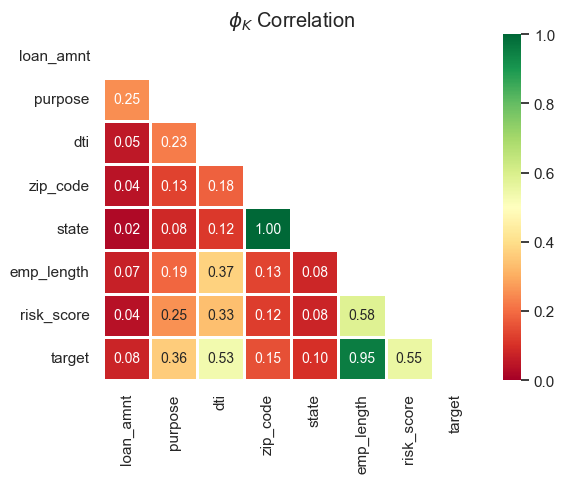

In [15]:
num_features = data_train_balanced.to_pandas().select_dtypes(include="number")
phik_corr = (
    data_train_balanced.drop(["date"])
    .to_pandas()
    .phik_matrix(interval_cols=num_features)
)
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
plt.figure(figsize=(6, 5))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    annot_kws={"size": 10},
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("$\phi_K$ Correlation")
plt.grid(False)
plt.show()

Unsurprisingly, most of the rejected loans are related to applicants employed for less than 1 year. On the other hand, the distribution of employment length is much more uniform for accepted loans except for the peak in 10 or more years of employment.

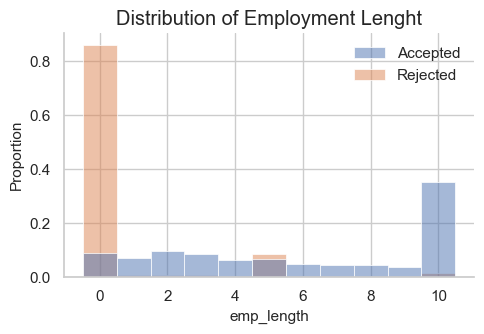

In [16]:
hist_params = {
    "hue": target,
    "hue_order": [1, 0],
    "common_norm": False,
    "stat": "proportion",
}
labels = {"labels": ["Accepted", "Rejected"]}
ax = sns.histplot(data=data_eda, x="emp_length", discrete=True, **hist_params)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.title("Distribution of Employment Lenght")
plt.show()

As per Lending Club policy, all loans with F score are rejected. The biggest proportion of rejected loans has D risk score. The most common risk score for accepted loans, is C.

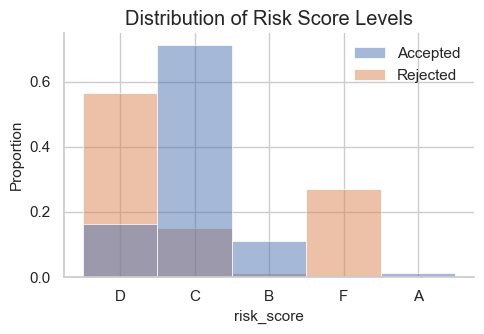

In [17]:
ax = sns.histplot(data=data_eda, x="risk_score", discrete=True, **hist_params)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.title("Distribution of Risk Score Levels")
plt.show()

Almost all accepted loans have DTI ratio lower that 40 and it is approximately normally distributed. On the other hand, DTI ratio for rejected loans has right-skewed distribution with many application listing 100 or even more.

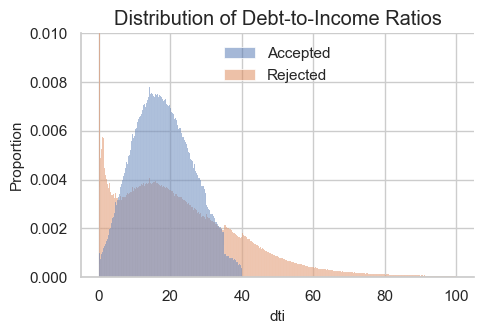

In [18]:
ax = sns.histplot(data=data_eda, x="dti", **hist_params)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.ylim([0, 0.01])
plt.title("Distribution of Debt-to-Income Ratios")
plt.show()

There are no clear differences between rejected and accepted loans in terms of loan purpose. Applicants of the accepted loans more often indicated that they want to consolidate debt or finance credit card. 

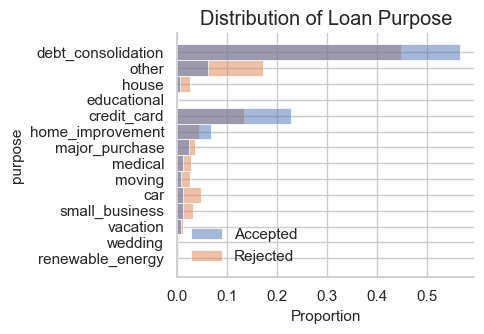

In [19]:
ax = sns.histplot(data=data_eda, y="purpose", discrete=True, **hist_params)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.title("Distribution of Loan Purpose")
plt.show()

Distributions of accepted and rejected loan amounts are similar, but rejected loans listed more small loans.

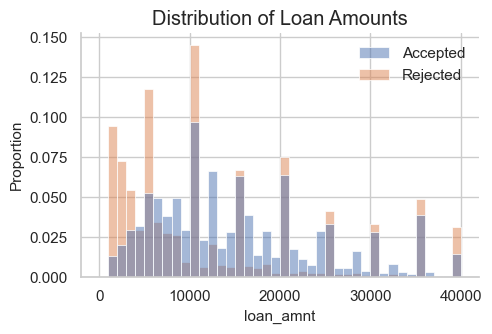

In [20]:
ax = sns.histplot(
    data=data_eda,
    x="loan_amnt",
    binwidth=1e3,
    binrange=[0, 4e4],
    **hist_params,
)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.title("Distribution of Loan Amounts")
plt.show()

### 3.5. <a id='toc3_5_'></a>Time and Geographical Insights      [&#8593;](#toc0_)

The median DTI has increased over the years for accepted and rejected loans.

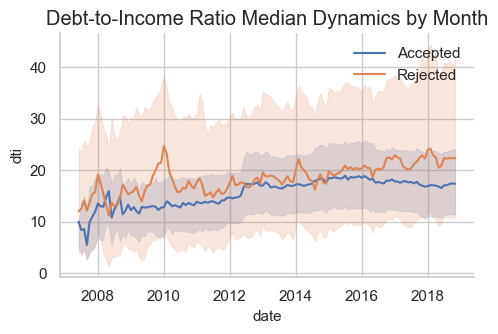

In [21]:
ax = sns.lineplot(
    data=data_eda,
    x="date",
    y="dti",
    hue=target,
    hue_order=[1, 0],
    estimator="median",
    errorbar=("pi", 50),
)
plt.legend(handles=ax.legend_.legend_handles, **labels)
plt.title("Debt-to-Income Ratio Median Dynamics by Month")
plt.show()

The state of Iowa stands out as a state with the lowest loan acceptance rate. However, this state also has a very low loan application count. On the other hand, the neighboring state of Minnesota has a very high loan acceptance rate of 10%.

In [22]:
state_acceptance = (
    data_eda.group_by("state")
    .agg(
        [
            pl.mean(target).alias("Acceptance Rate"),
            pl.count(target).alias("Application Count"),
        ]
    )
    .to_pandas()
)

state_names = pd.read_csv(
    "https://raw.githubusercontent.com/google/dspl/master/samples/google/canonical/states.csv "
)
state_acceptance = state_acceptance.merge(state_names, how="inner", on="state")

with urlopen(
    "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
) as response:
    state_geo = json.load(response)

state_geo_df = pd.json_normalize(pd.DataFrame(state_geo)["features"])
state_acceptance = state_acceptance.merge(
    state_geo_df[["id", "properties.name"]],
    how="inner",
    left_on="name",
    right_on="properties.name",
)
fig = px.choropleth_mapbox(
    state_acceptance,
    geojson=state_geo,
    locations="id",
    color="Acceptance Rate",
    color_continuous_scale="balance_r",
    mapbox_style="carto-positron",
    zoom=2,
    center={"lat": 45, "lon": -110},
    hover_name="name",
    hover_data={
        "id": False,
        "Application Count": True,
        "Acceptance Rate": ":.1%",
    },
    title="Loan Acceptance Rate in States",
    width=800,
    height=600,
)
fig.show()

### 3.6. <a id='toc3_6_'></a>Summary on Exploratory Data Analysis      [&#8593;](#toc0_)

1. The number of loan applications has been increasing throughout history, but the acceptance rate has been decreasing in recent years.
2. There are tendencies of loan rejection with applicants being employed for less than 1 year.
3. Risk score and DTI ratio are quantitative metrics of an applicant's creditworthiness, which are also implemented in the company's policy. A missing risk score or DTI, as well as a risk score of F or DTI higher than 50, already indicate loan rejection.
4. There is a tendency of DTI ratio increase, which indicates a worsening economic situation for loan applicants.
5. Acceptance rates are not uniform across the United States. Even though the zip code seems to be related to loan acceptance status, it has been chosen to be omitted from the model.

## 4. <a id='toc4_'></a>Loan Acceptance and Rejection Model      [&#8593;](#toc0_)

As a comparison, a basic heuristic-based model is used to evaluate classification performance improvement.

In [23]:
class BaseAcceptanceClassifier(BaseEstimator, ClassifierMixin):
    """Basic loan classifier which classifies loans as rejected if DTI is
    missing or over 50% or risk score is missing or belongs to F level."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        predictions = np.where(
            (X["risk_score"].isna())
            | (X["risk_score"] == "F")
            | (X["dti"].isna())
            | (X["dti"] > 50),
            0,
            1,
        )
        return predictions

    def predict_proba(self, X):
        probabilities = np.zeros((X.shape[0], 2))
        predictions = self.predict(X)
        probabilities[:, 1] = 1 - predictions
        probabilities[:, 0] = predictions
        return probabilities

As a starting point for the task of predicting loan acceptance, different models are tested with `lazypredict` (see `lazy_prediction_acceptance.ipynb` notebook). The task is quite simple as basic heuristics already performs very well. Most of the models have comparative performance, so the top one - XGBoost classifier - is chosen for tuning (see `tuning_acceptance.ipynb`). While tuning, dropping state, purpose and loan amount features are tried out; thus, the final model does not include state feature. The classifier includes a single estimator with the maximum depth of 13.

In [24]:
X_val, y_val = pd.read_pickle("./data/data_val_mod1.pkl").pipe(X_y_spilt)
X_test, y_test = pd.read_pickle("./data/data_test_mod1.pkl").pipe(X_y_spilt)
acceptance_model = joblib.load("./tuned_models/acceptance_model.joblib")
acceptance_model

Pipeline(steps=[('drop', FeatureDropper(drop_features=['state'])),
                ('processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('state',
                                                  Pipeline(steps=[('encoder',
                                                                   None)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B000B40750>),
                                                 ('purpose',
                                                  Pipeline(steps=[('encoder',
                                                                   WOEEncoder(regularization=2.5042270753252636,
                                                                              sig...
                               feature_types=None, gamma=0.14437331372653028,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=10, max_delta_step=None,
                               max_depth=13, max_leaves=None,
                               min_child_weight=9, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

### 4.1. <a id='toc4_1_'></a>Evaluation and Interpretation  [&#8593;](#toc0_)

On validation set, there is this slight increase in balanced accuracy and more pronounced increase in F1 score. False positives are reduced by double (from 12802 to 5874) at the expense of wrongly rejecting 151 loan. 

VALIDATION SET


,AUC-ROC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
XGBoost,0.999,0.983,0.996,0.877,0.993,0.995,0.933,0.970,0.931
Base,0.008,0.047,1.000,0.766,0.986,0.992,0.868,0.943,0.869


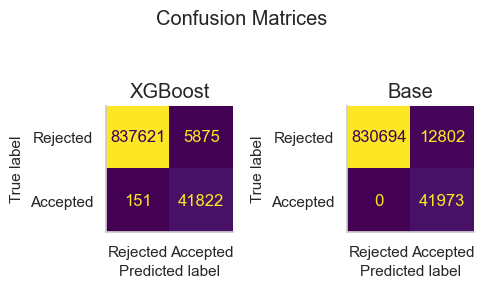

In [25]:
print("VALIDATION SET")
fig = score_binary_fitted_classifiers(
    ["XGBoost", "Base"],
    [acceptance_model, BaseAcceptanceClassifier()],
    X=X_val,
    y=y_val,
    labels=["Rejected", "Accepted"],
)
fig.set_figheight(3)

Same tendencies are seen on the test set. This time, false positives are reduced from 13891 to 6226 at the expense of falsely rejecting 185 loans.

TEST SET


,AUC-ROC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
XGBoost,0.999,0.982,0.995,0.865,0.993,0.994,0.926,0.966,0.924
Base,0.008,0.046,1.000,0.743,0.984,0.992,0.852,0.935,0.855


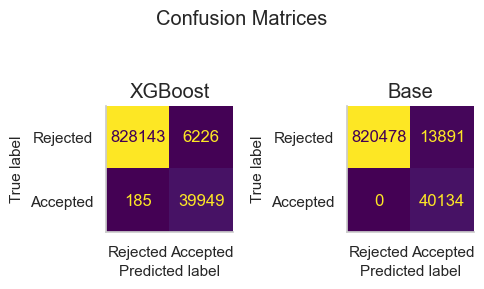

In [26]:
print("TEST SET")
fig = score_binary_fitted_classifiers(
    ["XGBoost", "Base"],
    [acceptance_model, BaseAcceptanceClassifier()],
    X=X_test,
    y=y_test,
    labels=["Rejected", "Accepted"],
)
fig.set_figheight(3)

Finally, it is seen that the model did not use much of the employment length to make the loan acceptance prediction. Risk score and DTI were the most important features.

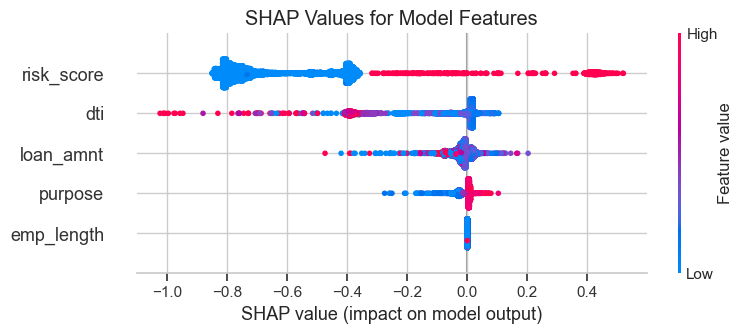

In [27]:
X_shap, _ = (
    pd.read_pickle("./data/data_test_mod1.pkl")
    .pipe(stratified_sample, frac=0.01)
    .pipe(X_y_spilt)
)
plot_shap_values(
    model=acceptance_model.named_steps["estimator"],
    data=X_shap,
    processor=Pipeline(acceptance_model.steps[:-1]),
    title="SHAP Values for Model Features",
)

### 4.2. <a id='toc4_2_'></a>Deployment  [&#8593;](#toc0_)

Model is saved for deployment without feature selector as it will simplify the request schema.

In [28]:
acceptance_model = joblib.load("./tuned_models/acceptance_model.joblib")
acceptance_clf = Pipeline(acceptance_model.steps[1:])
joblib.dump(acceptance_clf, "./deployment/acceptance_model_deploy.joblib")

['./deployment/acceptance_model_deploy.joblib']

Loan acceptance model is part of Lending Club service deployed at GCP. It can be reached via link at: https://lending-club-service-c4gigp2h5q-lm.a.run.app. To test the response of the model, a correctly formatted json can be provided at https://lending-club-service-c4gigp2h5q-lm.a.run.app/docs#/default/predict_predict_accept_post. Schema example:

In [29]:
sample = X_test.drop(columns="state").sample(n=1)
print(sample.to_json(orient="records").replace(":null", ':"nan"').strip("[]"))

{"loan_amnt":1000,"purpose":"vacation","dti":1.6399999857,"emp_length":3.0,"risk_score":"nan"}


### 4.3. <a id='toc4_3_'></a>Summary on Modeling [&#8593;](#toc0_)

1. Just risk score and DTI are highly predictive features of loan acceptance. The base model includes heuristics leveraging these features.
2. Most of the models perform very well because of an easy task.
3. Hyperparameter tuning does not substantially increase the performance of the model.
4. In the end, employment length does not seem as an important factor for loan acceptance.

## 5. <a id='toc5_'></a>Recommendations      [&#8593;](#toc0_)

* Missing risk score or F risk level, and missing DTI or DTI above 50% already indicate that a loan would be rejected. Simple heuristics based on these features perform well for the last months of the data.
* Zip code information should be removed from the model predicting loan acceptance to preserve customer privacy and ensure equality. On the other hand, state might be indicative of state-specific laws and taxation, but the feature ended-up being unimportant for the final model. 
* Loan acceptance model should be used as a rough indicator and a final decision should be validated by the person. This is because that totally automatic loan acceptance and rejection may introduce bias.

## 6. <a id='toc6_'></a>Suggestions for Improvement   [&#8593;](#toc0_)

* Since loan acceptance and rejection is a relatively easy task, a simpler model could be leveraged for it.
* To address class imbalance, majority class undersampling instead of class weighting could be a more appropriate approach. It might help to achieve higher F1 score (as shown in lazy prediction), as well as better calibrated classifier probabilities.
* If needed, another metric could be used to better represent a different business problem.
* Older data samples could be used for modelling with less weight.

----
**Lesson learned.** Never exclude a possibly informative feature right at the beginning without gathering enough domain information. Adding it later might change the whole course of modelling.